In [14]:
import os
os.environ["POLARS_LARGE_INDICES"] = "0"

In [15]:
import polars as pl
import numpy as np
import seaborn as sns
from src import config


In [17]:
PATH = config.RAW_DATA_PATH / "Sports_and_Outdoors_5core.json"
df = pl.read_ndjson(PATH)
df.head()
#df.info(memory_usage="deep")

overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
f64,str,bool,str,str,str,struct[1],str,str,str,i64
5.0,null,true,"""06 3, 2015""","""A180LQZBUWVOLF""","""0000032034""",null,"""Michelle A""","""What a spectacular tutu! Very …","""Five Stars""",1433289600
1.0,null,true,"""04 1, 2015""","""ATMFGKU5SVEYY""","""0000032034""",null,"""Crystal R""","""What the heck? Is this a tutu …","""Is this a tutu for nuns?!""",1427846400
5.0,null,true,"""01 13, 2015""","""A1QE70QBJ8U6ZG""","""0000032034""",null,"""darla Landreth""","""Exactly what we were looking f…","""Five Stars""",1421107200
5.0,null,true,"""12 23, 2014""","""A22CP6Z73MZTYU""","""0000032034""",null,"""L. Huynh""","""I used this skirt for a Hallow…","""I liked that the elastic waist…",1419292800
4.0,null,true,"""12 15, 2014""","""A22L28G8NRNLLN""","""0000032034""",null,"""McKenna""","""This is thick enough that you …","""This is thick enough that you …",1418601600


In [19]:
# ein User wird nicht mehr als eine Review gleichzeitig zum gleichen timestamp geschrieben haben können, daher können wir davon ausgehen,
# dass identische User Timestamp Paare unintended sind und sie bereinigen
df_cleaned = df.unique()
#df_cleaned = df_cleaned.filter(pl.col("verified_purchase") == True)
#check
print(f"Original row count: {len(df)}")
print(f"Cleaned row count:  {len(df_cleaned)}")

Original row count: 2839940
Cleaned row count:  2690149


In [25]:
df_cleaned_datetime = df_cleaned.with_columns(pl.from_epoch(pl.col("unixReviewTime"), time_unit="s"))
print(df_cleaned_datetime["unixReviewTime"].min(), df_cleaned_datetime["unixReviewTime"].max()) #sanity check by printing earliest and latest entry (should be 2000 and 2023)

2000-09-15 00:00:00 2018-10-04 00:00:00


<Axes: xlabel='overall', ylabel='count'>

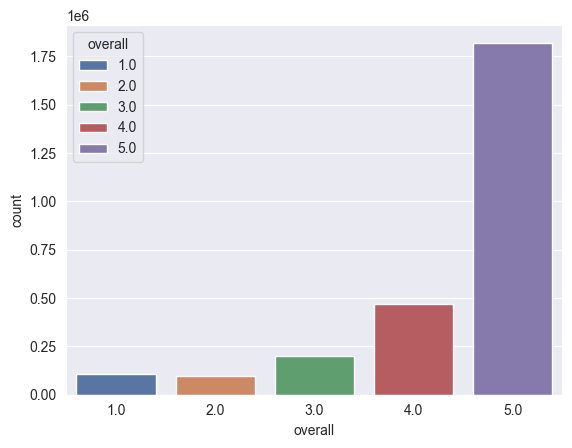

In [26]:
sns.countplot(x="overall", data=df_cleaned_datetime, hue="overall", palette="deep")

large overrepresentation of 5 star reviews, muss man schauen ob das später zum Problem wird, dann evtl. Loss Weighting anwenden oder Oversampling

In [28]:
avg_rating = df_cleaned_datetime["overall"].mean()
print(avg_rating)

4.413704965784423


**Mappings für Nutzer, Produkte und Features**

In [35]:
users = df_cleaned_datetime["reviewerID"].unique()
items = df_cleaned_datetime["asin"].unique()

print("Anzahl Items: ", items.shape)
print("Anzahl Nutzer: ", users.shape)

Anzahl Items:  (104687,)
Anzahl Nutzer:  (332447,)


In [36]:
user_to_index = {user_id: i for i, user_id in enumerate(users)}
item_to_index = {item_id: i for i, item_id in enumerate(items)}

index_to_user = {i: user_id for user_id, i in user_to_index.items()}
index_to_item = {i: item_id for item_id, i in item_to_index.items()}

df_cleaned_datetime = df_cleaned_datetime.with_columns([pl.col("reviewerID").replace(user_to_index).alias("user_index"),
                                                        pl.col("asin").replace(item_to_index).alias("item_index")])

In [39]:
df_cleaned_datetime.sort("user_index")
df_cleaned_datetime.drop(["reviewTime"])
df_cleaned_datetime.head()


overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,user_index,item_index
f64,str,bool,str,str,str,struct[1],str,str,str,datetime[μs],str,str
5.0,null,true,"""08 21, 2014""","""AD70LCQV7CSFN""","""B0076R6MN4""",{null},"""Oliver""","""Good buy. Columbia has always …","""Good buy. Columbia has always …",2014-08-21 00:00:00,"""143188""","""73325"""
5.0,"""2""",true,"""05 9, 2015""","""A2Y4KNB1JH9AAB""","""B004WHANTA""",null,"""mjo41232""","""Fixed all my screw ups on my A…","""The scratches matched perfect,…",2015-05-09 00:00:00,"""12323""","""85869"""
4.0,null,true,"""10 3, 2017""","""A1LCXJVM0JDPFT""","""B00SA91XVI""",{null},"""Zak""","""It's really well made and mayb…","""It's really well made and mayb…",2017-10-03 00:00:00,"""223297""","""77290"""
5.0,"""79""",false,"""09 9, 2015""","""ANFJYYQ0P35CW""","""B006RIV8HS""",null,"""Chris Jaronsky""","""I have been using my Dillon XL…","""THE BEST PROGRESSIVE RELOADER …",2015-09-09 00:00:00,"""162558""","""102955"""
5.0,null,true,"""03 2, 2014""","""AWW1LXV604IP4""","""B00BJLXPWE""",{null},"""Lance M.""","""I bought this for my three gun…","""great for three gun""",2014-03-02 00:00:00,"""179299""","""101698"""


**Final Step**

The following cell saves the processed dataset into a file so we can continue working with it later.
The Cleaning steps performed on this dataset were:
- remove Duplicates
- remove non-verified purchases
- convert timestamp to datetime
- add User Index
- add Item Index

In [36]:
df_cleaned_datetime.write_json(config.PROCESSED_DATA_PATH / "Sports_and_Outdoors_processed.jsonl")

In [33]:
from scipy.sparse import coo_matrix

interaction_data = np.ones(len(df), dtype=np.int32)
user_indices = df_cleaned_datetime['user_index'].to_numpy()
item_indices = df_cleaned_datetime['item_index'].to_numpy()

interactions_matrix = coo_matrix(
    (interaction_data, (user_indices, item_indices)),
    shape=(len(users), len(items))
)
print("\nInteraktionsmatrix erstellt.")

ValueError: all index and data arrays must have the same length

In [35]:
# Führe dies direkt nach dem Laden und Auswählen der Spalten aus
print("Überprüfung auf null-Werte:")
print(df_cleaned_datetime.null_count())

Überprüfung auf null-Werte:
shape: (1, 12)
┌────────┬───────┬──────┬────────┬───┬──────────────┬───────────────────┬────────────┬────────────┐
│ rating ┆ title ┆ text ┆ images ┆ … ┆ helpful_vote ┆ verified_purchase ┆ user_index ┆ item_index │
│ ---    ┆ ---   ┆ ---  ┆ ---    ┆   ┆ ---          ┆ ---               ┆ ---        ┆ ---        │
│ u32    ┆ u32   ┆ u32  ┆ u32    ┆   ┆ u32          ┆ u32               ┆ u32        ┆ u32        │
╞════════╪═══════╪══════╪════════╪═══╪══════════════╪═══════════════════╪════════════╪════════════╡
│ 0      ┆ 0     ┆ 0    ┆ 0      ┆ … ┆ 0            ┆ 0                 ┆ 0          ┆ 0          │
└────────┴───────┴──────┴────────┴───┴──────────────┴───────────────────┴────────────┴────────────┘
